In [22]:
# Let's make the code cells wider, we've got a big screen for a reason!
from IPython.core.display import display, HTML, Markdown
display(HTML("<style>.container { width:85% !important; }</style>"))

### Import and dataset

In [23]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification, load_iris

Let's make a fake numeric dataset for the purpose of our examples.

We'll do this by using scikit-learn's helpful `make_classification` function.

<mark>You can 'unpack' arguments into a function via a dictionary using the `**` notation (see below).</mark>

In [24]:
make_classification_dict = {'n_samples': 100000, 'n_features': 50}

sample_data = make_classification(**make_classification_dict)

Let's look at our X:

In [25]:
X = pd.DataFrame(sample_data[0])
X.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.144940,-2.973234,-0.543606,1.152905,0.472824,0.303314,-0.619648,-0.207515,-0.162394,-0.641720,...,-0.910025,-0.876951,-0.009114,-1.383746,-1.035541,-1.574781,-0.242429,0.159833,-0.635713,0.926864
1,-0.154604,0.678811,-0.300190,0.579631,1.249691,1.198227,0.393885,-1.028497,1.108154,0.757240,...,1.098791,1.001878,-1.287695,-1.112392,-0.549235,0.688385,-0.879132,-1.077289,-0.601772,0.466776
2,1.606411,-1.015473,0.468781,1.637380,1.280078,-1.377780,-0.218473,-1.287791,-0.877043,-0.211678,...,0.578872,-1.179975,-0.900956,1.565332,0.001468,-0.921548,-0.476031,-0.111182,-1.532239,-0.453910
3,1.009242,-0.918627,-0.924404,-0.720755,1.064838,-1.238482,-1.198147,0.401047,-1.091971,0.892662,...,0.397026,0.541624,-1.816048,0.876922,1.350898,-0.325211,-0.802912,-1.302864,0.713262,0.639911
4,0.958570,2.447725,2.280817,0.253469,-0.418514,-0.006410,0.284025,0.620447,0.800770,-1.616347,...,0.208342,-1.312397,-0.336822,1.356428,-0.368574,0.958734,2.137438,0.048407,1.301884,0.010916


Let's look at our y: <br>
<mark>You can continue code onto the next line with `\` (see below)</mark>

In [26]:
y = pd.Series(sample_data[1])\
.to_frame()
y.head()

,0
0,0
1,0
2,1
3,1
4,1


#### Pipelines
<img style="float: center;width:250px;height:150px;" src="images/simple_pipelines.gif">

Prior to pipelines, the best way of organising the steps in your model would be to define separate variables for all steps.


Disadvantages
* Polluting the namespace
* Potential data leakage

In [103]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [104]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() #we instantiate the scaler object
X_train_scaled = scaler.fit_transform(X_train) #we fit and transform X into the scaler object using .fit_transform()

Now let's say we want to apply a logistic regression.

In [105]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train_scaled, y_train.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [106]:
logreg.score(X_test, y_test)

0.88596

Now, imagine we've got lots of steps, <br>
let's say we're applying a `VarianceThreshold()` or a `SelectKBest` <br>
We would have to do the following.

In [107]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest

k_best = SelectKBest(k = 'all')
X_train_k_best = k_best.fit_transform(X_train, y_train.values.ravel())

scaler = StandardScaler() #we instantiate the scaler object
X_train_scaled = scaler.fit_transform(X_train_k_best) #we fit and transform X into the scaler object using .fit_transform()

var_thres = VarianceThreshold(threshold = 0.0)
X_train_var_thresh = var_thres.fit_transform(X_train_scaled)

logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train_var_thresh, y_train.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Now we have to apply the same steps to the test data. <br>
But in a way which avoids data leakage. <br>
We have to use the _information learned from the train data_ and apply it to our test data.

In [108]:
X_test_k_best = X_test.iloc[:, k_best.get_support(indices=True)]

X_test_scaled = scaler.transform(X_test_k_best)

X_test_var_thresh = var_thres.transform(X_test_scaled)

In [109]:
logreg.score(X_test_var_thresh, y_test)

0.89212

Let's plot the anova p_values.

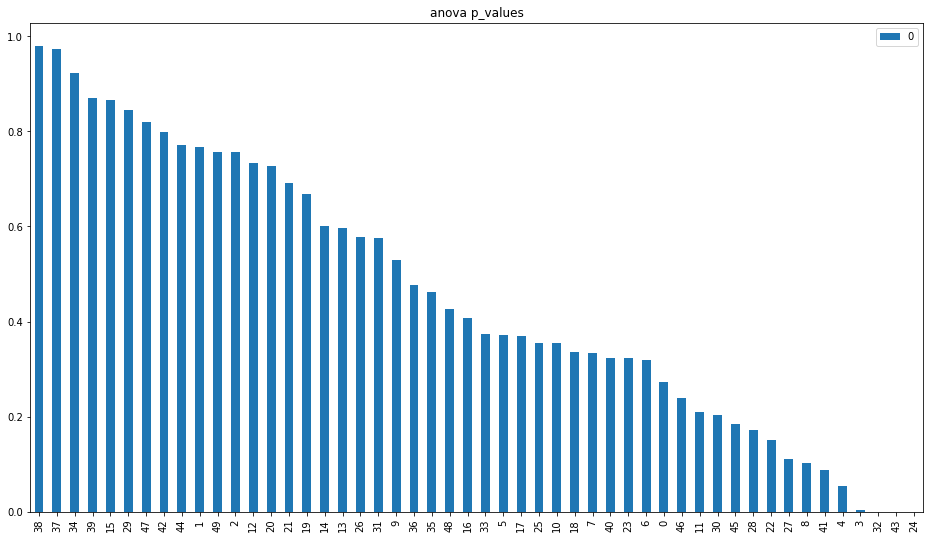

In [110]:
from matplotlib import pyplot as plt
pd.DataFrame(k_best.pvalues_).sort_values(0, ascending = False).plot(kind = 'bar', title= 'anova p_values', figsize = (16, 9))

The above isn't ideal, and doesn't scale very well with large processes.

What if we want cross-validation with some parameter tuning?

<div class="alert alert-block alert-warning">
<b>Warning:</b> The code cell below takes a while to run, so feel free to skip.
</div>

In [111]:
import numpy as np
from sklearn.model_selection import GridSearchCV

logreg_cv = GridSearchCV(cv = 5, estimator=LogisticRegression(solver = 'lbfgs'),
                         param_grid={'C': np.logspace(-4, 4, num = 9)})
logreg_cv.fit(X_train_scaled, y_train.values.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [112]:
logreg_cv.best_estimator_.score(X_test_scaled, y_test)
logreg_cv_y_pred = logreg_cv.predict(X_test)
logreg_cv_y_scores = logreg_cv.predict_proba(X_test)

<div class="alert alert-block alert-danger">
<b>Oh no:</b> We have just commited <b>data leakage.<b>
</div>
    
But... how? <br>
We are using values scaled (`StandardScalar`) to the *whole population* in a cross-validation (`GridSearchCV`) with data that is less than the *whole population*. <br>

A pipeline could have prevented this, let's convert the example above into one such form.

<div class="alert alert-block alert-warning">
<b>Warning:</b> The code cell below takes a while to run, so feel free to skip.
</div>

In [113]:
log_reg_pipe = make_pipeline(
    SelectKBest(k='all')
    ,VarianceThreshold()
    ,StandardScaler()
    ,LogisticRegression(solver = 'lbfgs')
)

pg = {'logisticregression__C': np.logspace(-4, 4, num = 9)}

log_reg = GridSearchCV(cv = 5, estimator = log_reg_pipe, param_grid= pg)
log_reg.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('selectkbest',
                                        SelectKBest(k='all',
                                                    score_func=<function f_classif at 0x7fd27b20f400>)),
                                       ('variancethreshold',
                                        VarianceThreshold(threshold=0.0)),
                                       ('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           cl...
                                                           max_iter=100,
             

Now values are scaled **within each k-fold**.

In [114]:
log_reg.get_params()

{'cv': 5,
 'error_score': 'raise-deprecating',
 'estimator__memory': None,
 'estimator__steps': [('selectkbest',
   SelectKBest(k='all', score_func=<function f_classif at 0x7fd27b20f400>)),
  ('variancethreshold', VarianceThreshold(threshold=0.0)),
  ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('logisticregression',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=100,
                      multi_class='warn', n_jobs=None, penalty='l2',
                      random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                      warm_start=False))],
 'estimator__verbose': False,
 'estimator__selectkbest': SelectKBest(k='all', score_func=<function f_classif at 0x7fd27b20f400>),
 'estimator__variancethreshold': VarianceThreshold(threshold=0.0),
 'estimator__standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'estimator__logi

In [115]:
log_reg.best_params_

{'logisticregression__C': 0.1}

We can score the pipeline as normal.

In [116]:
log_reg.score(X_test_scaled, y_test)

0.87844

Let's apply this pipeline on a new dataset!

In [117]:
load_iris()['target'].shape

(150,)

In [118]:
iris_X = load_iris()['data']
iris_y = load_iris()['target']
iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(iris_X, iris_y, stratify = iris_y)

In [119]:
from sklearn.pipeline import clone

# First we clone the pipeline so we can still use the steps
# of the previously trained data without interfering with logreg.
log_reg_iris = clone(log_reg)
# Setting the multi_class parameter to 'auto' due to this problem having three classes
log_reg_iris.estimator.named_steps['logisticregression'].multi_class = 'auto'
# Increasing max_iter so the SGD algorithm has more time to converge
log_reg_iris.estimator.named_steps['logisticregression'].max_iter = 1000
# Setting values to avoid future warnings
log_reg_iris.error_score = 'raise'
log_reg_iris.iid = False

In [120]:
# Then we fit as normal
log_reg_iris.fit(iris_X_train, iris_y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(memory=None,
                                steps=[('selectkbest',
                                        SelectKBest(k='all',
                                                    score_func=<function f_classif at 0x7fd27b20f400>)),
                                       ('variancethreshold',
                                        VarianceThreshold(threshold=0.0)),
                                       ('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=N...
                                                           max_iter=1000,
            

In [121]:
log_reg_iris.score(iris_X_test, iris_y_test)

0.9210526315789473

In [122]:
iris_log_reg_y_pred = log_reg_iris.predict(iris_X_test)
iris_log_reg_y_scores = log_reg_iris.predict_proba(iris_X_test)

It's as simple as that. <br>

[Scikit-Learn Pipeline Guide](https://scikit-learn.org/stable/modules/compose.html)

#### Pipelines as objects

Pipelines are objects, let's say we want to change the final step to SVM rather than Logistic, this is one way.

In [123]:
from sklearn.svm import SVC
svm_pipe = clone(log_reg_pipe)

We can access the steps in a pipelines two ways: <br>
`.named_steps` gives a dictionary. <br>
`.steps` gives a series of tuples.

In [124]:
svm_pipe.named_steps

{'selectkbest': SelectKBest(k='all', score_func=<function f_classif at 0x7fd27b20f400>),
 'variancethreshold': VarianceThreshold(threshold=0.0),
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False)}

In [125]:
svm_pipe.steps[-1]

('logisticregression',
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False))

Now let's redefine the last step in the pipeline.

In [126]:
svm_pipe.steps[-1] = ('svc', SVC(random_state=0, verbose=True))

We can see now that the pipeline has changed.

In [127]:
svm_pipe.named_steps

{'selectkbest': SelectKBest(k='all', score_func=<function f_classif at 0x7fd27b20f400>),
 'variancethreshold': VarianceThreshold(threshold=0.0),
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'svc': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
     kernel='rbf', max_iter=-1, probability=False, random_state=0,
     shrinking=True, tol=0.001, verbose=True)}

In [128]:
svm_pg = {"svc__kernel": ['rbf']
         ,"svc__C": [0.1]
         ,"svc__gamma": [0.001]}

svm_iris = GridSearchCV(cv = 3, estimator = svm_pipe, param_grid = svm_pg, iid=False)
svm_iris.fit(iris_X_train, iris_y_train.ravel())

[LibSVM][LibSVM][LibSVM][LibSVM]

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('selectkbest',
                                        SelectKBest(k='all',
                                                    score_func=<function f_classif at 0x7fd27b20f400>)),
                                       ('variancethreshold',
                                        VarianceThreshold(threshold=0.0)),
                                       ('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('svc',
                                        SVC(C=1.0, cache_size=200,
                                            class_weight=None...
                                            decision_function_shape='ovr',
                         

In [129]:
svm_iris.score(iris_X_test, iris_y_test)
iris_svm_y_pred = svm_iris.predict(iris_X_test)

### Complex pipelines
What happens when we want to apply different pipelines to different columns of our data? <br>

<img style="float: left;" src="images/complex_pipelines.gif">

In [130]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
# Categorical Columns
fill_to_zero = [0]
# Define steps in pipeline
cat_pipe = make_pipeline(SimpleImputer(strategy="constant", fill_value=0))

Now we'll make a new pipeline.

In [131]:
preprocessing = make_column_transformer((cat_pipe, fill_to_zero), remainder="passthrough")

The below is a lot to take in, let's take it step by step. <br>
1. First we use C_base and C_list to create a list of potential `C` that we will grid search over. <br>
`C` is the inverse of the regularisation strength. <br>
1. Then the pipeline begins, we run the data through the "preprocessing" pipeline defined above. <br>
1. Then we impute with the median. <br>
1. Then we run the data through a Random Forest to see what the feature importances are. <br>
1. Only the top 20 features progress to the next stage. This can be useful when dealing with hundreds of features. <br>
1. Next all values are scaled such that the mean is 0 and the variance is 1 (unit variance). <br>
1. Finally the data is run through `LogisticRegressionCV`, think of this as `LogisticRegression` combined with `GridSearchCV`, this approach can be quicker due to a backend phenonmenon called *warm starting* (using the previous solution as an initialization for the following fit).

In [132]:
C_base = 4
C_list = np.logspace(-C_base, +C_base, num=(2 * C_base) + 1)
lr_pipe = make_pipeline(
    preprocessing,
    SimpleImputer(strategy="median"),
    SelectFromModel(RandomForestClassifier(random_state=0, n_estimators=20)),
    StandardScaler(),  # Adding in a standard scaling step, relative to the dtc section.
    LogisticRegressionCV(random_state=0, solver="saga", cv=5, penalty="l1", class_weight="balanced", scoring="accuracy", max_iter=10000, n_jobs=-1, multi_class='ovr')
)

In [133]:
lr_pipe.fit(iris_X_train, iris_y_train.ravel())

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=0,
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                       

In [134]:
iris_y_train

array([1, 2, 0, 2, 0, 0, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 0, 1, 1,
       0, 2, 1, 1, 0, 2, 2, 0, 1, 1, 0, 2, 1, 0, 1, 2, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 2, 1, 0, 1, 2, 1,
       1, 2, 1, 1, 2, 2, 1, 2, 0, 0, 2, 0, 2, 2, 1, 0, 0, 0, 1, 2, 2, 1,
       2, 0, 2, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 2, 2, 1, 0, 2, 2, 0,
       0, 2])

In [135]:
iris_X_train.shape

(112, 4)

In [136]:
lr_pipe.score(iris_X_test, iris_y_test)

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:2257: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


0.8947368421052632

**A quick note on feature names**
So we've applied a lot of steps here.
But interpretability is important, so it would be good to know what features went into the final step.

A simple `pipeline.get_feature_names()` is not yet implemented in scikit-learn. <br>
But the pipeline above is not too long, so we can do this manually.

Below is an example that works for a pipeline with many features, I'll talk through how each step works, but first here's the example pipeline.

**Preprocessing pipeline**

```
# Categorical Columns
categoric_variables = ["CITY"]
# Define steps in pipeline
cat_pipe = make_pipeline(SimpleImputer(strategy="constant", fill_value="0"), OneHotEncoder(handle_unknown="ignore"))


# Column transformer to deal with the categoric variable
preprocessing = make_column_transformer((cat_pipe, categoric_variables), remainder="passthrough")

```

**Random Forest Pipeline**

```
# Random Forest
`rf_pipe = make_pipeline(preprocessing
                        ,SimpleImputer(strategy="median")
                        ,VarianceThreshold()
                        ,RandomForestClassifier(random_state=0))
rf_parameters = {"randomforestclassifier__class_weight": ["balanced"]
                ,"randomforestclassifier__n_estimators": [20, 50, 70, 100]}
                
rf_gs = GridSearchCV(rf_pipe
                    ,param_grid = rf_parameters
                    ,scoring=scoring_list
                    ,refit="roc_auc"
                    ,return_train_score=False
                    ,cv=5)
```


```
feature_names = list(pipe.named_steps.columntransformer.named_transformers_.pipeline.named_steps.onehotencoder.get_feature_name(categoric_variables)) +
[column for column in X.columns if column not in categoric_variables]

feature_names = [list(feature_names)[i] for i in pipe.named_steps.variancethreshold.get_support(indices=True)]
```

### Useful Packages

In [137]:
import eli5
eli5.explain_weights_sklearn(log_reg_iris.best_estimator_.named_steps.logisticregression)

Explanation(estimator="LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,\n                   intercept_scaling=1, l1_ratio=None, max_iter=1000,\n                   multi_class='auto', n_jobs=None, penalty='l2',\n                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,\n                   warm_start=False)", description="\nFeatures with largest coefficients per class.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='x1', weight=2.049892993376642, std=None, value=None), FeatureWeight(feature='<BIAS>', weight=0.21674949052495926, std=None, value=None)], neg=[FeatureWeight(feature='x3', weight=-3.2014665508660176, std=None, value=None), FeatureWeight(feature='x2', weight=-3.185448073485341, std=None, value=None), FeatureWeight(feature='x0', weight=-1.4481874972731348, std=None, value=None)], pos_remaining=0, neg_remaining=0), proba=None, score=None, weighted_spans=None), TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=3.730075727179248, std=None, value=None), FeatureWeight(feature='x0', weight=1.1644359755513622, std=None, value=None)], neg=[FeatureWeight(feature='x3', weight=-1.686807336777237, std=None, value=None), FeatureWeight(feature='x2', weight=-1.3295452702856174, std=None, value=None), FeatureWeight(feature='x1', weight=-0.6429510299751146, std=None, value=None)], pos_remaining=0, neg_remaining=0), proba=None, score=None, weighted_spans=None), TargetExplanation(target=2, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='x3', weight=4.888273887643265, std=None, value=None), FeatureWeight(feature='x2', weight=4.514993343770957, std=None, value=None), FeatureWeight(feature='x0', weight=0.2837515217217607, std=None, value=None)], neg=[FeatureWeight(feature='<BIAS>', weight=-3.946825217704232, std=None, value=None), FeatureWeight(feature='x1', weight=-1.4069419634015237, std=None, value=None)], pos_remaining=0, neg_remaining=0), proba=None, score=None, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

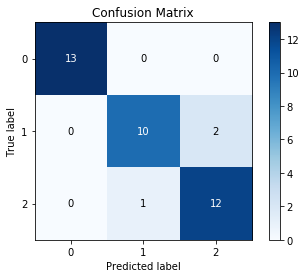

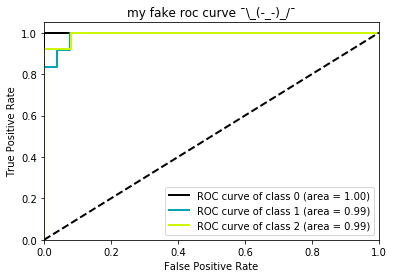

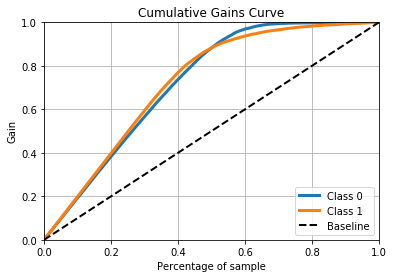

In [138]:
from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_cumulative_gain
plot_confusion_matrix(iris_y_test, iris_log_reg_y_pred)
plot_roc(iris_y_test, iris_log_reg_y_scores, title = 'my fake roc curve ¯\_(-_-)_/¯', plot_micro = False, plot_macro = False)
plot_cumulative_gain(y_test, logreg_cv_y_scores)

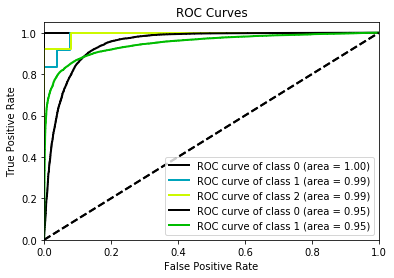

In [139]:
test = plt.axes()

plot_roc(iris_y_test, iris_log_reg_y_scores, ax = test, plot_macro = False, plot_micro = False)
plot_roc(y_test, logreg_cv_y_scores, ax = test, plot_macro = False, plot_micro = False)